In [1]:
import os
import torch 
import numpy as np
import sys
import pandas as pd
import math
import copy
from typing import  *
from torch.nn import LayerNorm
from torch import nn
from torch.nn import functional as F
from torch.nn import Module
from torch import nn, Tensor
from matplotlib import pyplot as plt

In [2]:
def attention( 
    query,
    key,
    value
):
    # W_q  , W_k , W_v
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1)/math.sqrt(d_k))
    scores = F.softmax(scores, dim=-1)
    attn_x = torch.matmul(scores, value)
    return attn_x, scores

In [3]:
query = torch.rand(10,4,6)
key = torch.rand(10,4,6)
value = torch.rand(10,4,6)

In [4]:
class multiHeadAttention(Module):
    def __init__(
        self,
        emb_dim,
        qkv_dim,
        num_heads = 5
    ):
        super(multiHeadAttention,self).__init__()
        self._W_q = nn.ModuleList( [nn.Linear(emb_dim, qkv_dim) for _ in range(num_heads)])
        self._W_k = nn.ModuleList( [nn.Linear(emb_dim, qkv_dim) for _ in range(num_heads)])
        self._W_v = nn.ModuleList( [nn.Linear(emb_dim, qkv_dim) for _ in range(num_heads)])
        self.num_heads = num_heads
        self.qkv_dim = qkv_dim
        self.emb_dim = emb_dim
        self.ff = nn.Linear(num_heads*qkv_dim, qkv_dim)
    
    def forward(self, K, Q, V):
       
        # for each head
        pr_query = [ self._W_v[i](K) for i in range(self.num_heads)]
        pr_key = [ self._W_k[i](Q) for i in range(self.num_heads)]
        pr_value = [ self._W_v[i](V) for i in range(self.num_heads)]
        
        # Calculate self attention for each head
        attn_x = []
        for i in range(self.num_heads):    
            _attn_x, scores = attention( 
                pr_query[i],
                pr_key[i],
                pr_value[i]
            )
            attn_x.append(_attn_x)
        attn_x = torch.cat(attn_x, dim =-1)
        
        # apply final feedforward network 
        x = self.ff(attn_x)
        print(x.shape)
        return x

In [5]:
mha_obj = multiHeadAttention(
    emb_dim = 12,
    qkv_dim = 12,
)

In [6]:
query = torch.rand(10,4,12)
key = torch.rand(10,4,12)
value = torch.rand(10,4,12)
x = mha_obj(query, key, value)

torch.Size([10, 4, 12])


In [7]:
# Build encoder and decoder



In [8]:
class PositionalEncoding(nn.Module):
    def __init__(
        self, 
        d_model: int, 
        dropout: float = 0.0, 
        max_len: int = 1000
    ):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [9]:
pe = PositionalEncoding(12)


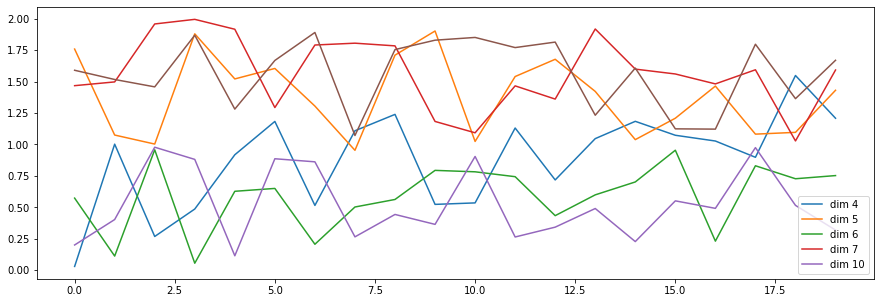

In [10]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(12, 0)
y = pe.forward(Tensor(torch.rand(10, 20, 12)))
plt.plot(
    np.arange(20), 
    y[0, :, 4:10].data.numpy()
)
plt.legend(["dim %d"%p for p in [4,5,6,7,10]])


In [11]:
'''
Single encoder layer
'''
class EncoderLayer(nn.Module):
   
    def __init__(
        self, 
        size :int, 
        dropout: float,
        num_heads: int
    ):
        super(EncoderLayer, self).__init__()
        
        self.multiHeadAttention =  multiHeadAttention(
            emb_dim = size,
            qkv_dim = size,
            num_heads = num_heads 
        )
        
     
        self.size = size
        self.dropout_1 = nn.Dropout(dropout)
        self.norm_1 = LayerNorm(size)
        self.dropout_2 = nn.Dropout(dropout)
        
        self.norm_2 = LayerNorm(size)
        
        
        self.feed_forward = nn.Linear(size,size)
         
        
    def forward(
        self, 
        x_input
    ):
        # First : self attention 
        x1 = self.multiHeadAttention(x, x, x)
        # Add and normalize 
        x2 = x1 + self.dropout_1(self.norm_1(x1))
        # Feed forward
        x3 = self.feed_forward(x2)
        # Add and normalize 
        x4 = x3 + self.dropout_2(self.norm_2(x1))
        return x4
    

In [12]:
EncoderLayer(
    size=8,  
    dropout=0.05,
    num_heads=6
)

EncoderLayer(
  (multiHeadAttention): multiHeadAttention(
    (_W_q): ModuleList(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): Linear(in_features=8, out_features=8, bias=True)
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): Linear(in_features=8, out_features=8, bias=True)
      (4): Linear(in_features=8, out_features=8, bias=True)
      (5): Linear(in_features=8, out_features=8, bias=True)
    )
    (_W_k): ModuleList(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): Linear(in_features=8, out_features=8, bias=True)
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): Linear(in_features=8, out_features=8, bias=True)
      (4): Linear(in_features=8, out_features=8, bias=True)
      (5): Linear(in_features=8, out_features=8, bias=True)
    )
    (_W_v): ModuleList(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): Linear(in_features=8, out_features=8, bias=True)
      (2): Linear(

In [13]:
enc = EncoderLayer( size=8,  
    dropout=0.05,
    num_heads=6
)

In [14]:
x = torch.rand(10,5,8)

In [15]:
enc(x).shape

torch.Size([10, 5, 8])


torch.Size([10, 5, 8])

In [ ]:
inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    
inp_mask[encoded_texts <= 2] = False
# Set targets to -1 by default, it means ignore
labels = -1 * np.ones(encoded_texts.shape, dtype=int)
# Set labels for masked tokens
labels[inp_mask] = encoded_texts[inp_mask]